# Synthetized Cone Data Generation

### Imports

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm
import pylab as plt

### Utils

In [2]:
def plot_cone(X, Y, Z, wireframe=True, points=30, axis=False):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if wireframe:
        ax.plot_wireframe(X, Y, Z, rcount=points, ccount=points)
    else:
        colors =plt.cm.gray( (X-X.min())/float((X-X.min()).max()) )
        ax.plot_surface(X, Y, Z, rcount=points, ccount=points, facecolors=colors, shade=False)
    
    if not axis:
        ax.axis('off')
    else:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
    
    ax.view_init(elev=10., azim=0)
    
    plt.show()

In [3]:
# check for possibilities of denoting depth with colors (grayscale and depth)
# already used surface_colors but it's not really evident and it may need to depend on the pov (car relative position)

### Cone Generation 

#### Methods

In [4]:
def truncated_cone(p0, p1, R0, R1):
    """
    Based on https://stackoverflow.com/a/39823124/190597 (astrokeat)
    """
    # vector in direction of axis
    v = p1 - p0
    # find magnitude of vector
    mag = norm(v)
    # unit vector in direction of axis
    v = v / mag
    # make some vector not in the same direction as v
    not_v = np.array([1, 1, 0])
    if (v == not_v).all():
        not_v = np.array([0, 1, 0])
    # make vector perpendicular to v
    n1 = np.cross(v, not_v)
    # print n1,'\t',norm(n1)
    # normalize n1
    n1 /= norm(n1)
    # make unit vector perpendicular to v and n1
    n2 = np.cross(v, n1)
    # surface ranges over t from 0 to length of axis and 0 to 2*pi
    n = 80
    t = np.linspace(0, mag, n)
    theta = np.linspace(0, 2 * np.pi, n)
    # use meshgrid to make 2d arrays
    t, theta = np.meshgrid(t, theta)
    R = np.linspace(R0, R1, n)
    # generate coordinates for surface
    X, Y, Z = [p0[i] + v[i] * t + R *
               np.sin(theta) * n1[i] + R * np.cos(theta) * n2[i] for i in [0, 1, 2]]
    return X, Y, Z
    # ax.plot_surface(X, Y, Z, color=color, linewidth=0, antialiased=False)

In [5]:
def generate_plot(point_base, point_tip, range_base, range_tip, wireframe=False, axis=False):
    X, Y, Z = truncated_cone(point_base, point_tip, range_base, range_tip)
    plot_cone(X, Y, Z, wireframe=wireframe, axis=axis)

#### Demo

In [6]:
point_base = np.array([0, 0, 0]) # point from the base
point_tip = np.array([0, 0, 10]) # point from the truncated tip
range_base = 8 # range base
range_tip = 3 # range truncated tip
X, Y, Z = truncated_cone(point_base, point_tip, range_base, range_tip)

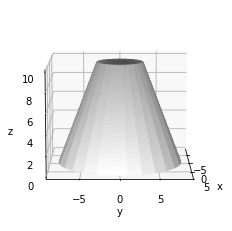

In [7]:
plot_cone(X, Y, Z, wireframe=False, axis=True)

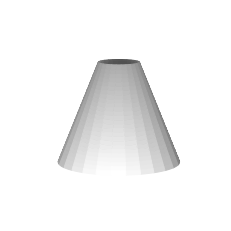

In [12]:
generate_plot(np.array([0, 0, 0]), np.array([0, 0, 20]), 15, 5)

### Cone Rotation

#### Methods

In [13]:
import math as m
  
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(theta):
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(theta):
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

In [14]:
def rotate_tip(tip_coordinates, phi = m.pi/2, theta = m.pi/4, psi = m.pi/2):
    tip_coordinates = tip_coordinates.reshape((3, 1))
    R = Rz(psi) * Ry(theta) * Rz(phi)
    rotated_tip = (R * tip_coordinates)
    return np.array([rotated_tip.item(0),rotated_tip.item(1), rotated_tip.item(2)])

In [15]:
def rotated_cone(point_base, point_tip, range_base, range_tip, phi = 0, theta = 0, psi = 0):
    phi, theta, psi = m.radians(phi), m.radians(theta), m.radians(psi)   
    rotated_tip = rotate_tip(point_tip, phi, theta, psi)
    return truncated_cone(point_base, rotated_tip, range_base, range_tip)

In [34]:
def save_cone(X, Y, Z, file_name="cone.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, rcount=100, ccount=100, color="black")
    
    ax.axis('off')
    
    ax.view_init(elev=10., azim=0)
    
    plt.savefig(file_name)

def save_rotated_cones(point_base=np.array([0, 0, 0]), point_tip=np.array([0, 0, 20]), range_base=15, range_tip=5):
    # generating the vertical cone
    X, Y, Z = truncated_cone(point_base, point_tip, range_base, range_tip)
    #saving the vertical cone
    save_cone(X, Y, Z, "cones/v_cone.png")
    
    for psi in range(0,360):
        X_r, Y_r, Z_r = rotated_cone(point_base, point_tip, range_base, range_tip, 0, 120, psi)
        file_name = "cones/h_cone_" + str(psi) +".png"
        save_cone(X_r, Y_r, Z_r, file_name)

In [ ]:
save_rotated_cones()

#### Demo

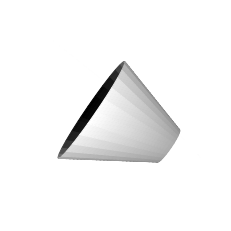

In [30]:
phi = 0     # x axis
theta = 120   # y axis
psi = 90    # z axis
X_r, Y_r, Z_r = rotated_cone(point_base, point_tip, range_base, range_tip, phi, theta, psi)
plot_cone(X_r, Y_r, Z_r, wireframe=False)

### Cone Comparison

In [20]:
def compare_cones(X_a,Y_a,Z_a, X_b, Y_b, Z_b, wireframe = True, points=30, axis = False):
    fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))

    # cone 3d plot
    if wireframe == True:
        axes[0].plot_wireframe(X_a, Y_a, Z_a, rcount=points, ccount=points)
        axes[1].plot_wireframe(X_b, Y_b, Z_b, rcount=points, ccount=points)
    else: 
        axes[0].plot_surface(X_a, Y_a, Z_a, rcount=points, ccount=points)
        axes[1].plot_surface(X_b, Y_b, Z_b, rcount=points, ccount=points)
        
    
    if not axis:
        axes[0].axis("off")
        axes[1].axis("off")
    else:
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("y")
        axes[0].set_zlabel("z")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")
        axes[1].set_zlabel("z")
    
    axes[0].view_init(elev=10., azim=0)
    axes[1].view_init(elev=10., azim=0)

    plt.show()

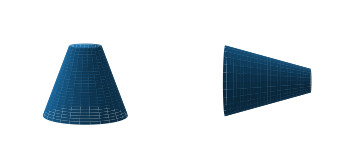

In [21]:
compare_cones(X, Y, Z, X_r, Y_r, Z_r, wireframe=False)

## LiDAR-like Sampling

In [ ]:
from matrix_convertion import convert_image_to_matrix

def get_offset_from_distance(distance, dist_min = 1, dist_max = 200, offset_min = 7, offset_max = 30):
    # get distance percent
    dist_percent = ( distance / dist_max )*100 
    
    # get offset for 1%
    offset_scale_factor = (offset_max - offset_min)/100
    
    distance_scale_factor = round(dist_percent * offset_scale_factor) + offset_min
    print(distance_scale_factor)
    return distance_scale_factor, distance_scale_factor
    
def LiDAR_sampling(file_name, distance=1):
    i_img = convert_image_to_matrix(file_name)
    img_width, img_height = i_img.shape[0], i_img.shape[1]
    x_offset, y_offset = get_offset_from_distance(distance)
    o_img = np.zeros(i_img.shape)
    
    for i in range(0, img_width, x_offset):
        for j in range(0, img_height, y_offset):
            if i_img[i][j] != 0:
                o_img[i][j] = i_img[i][j]
    
    plt.imshow(o_img, cmap='gray')

7


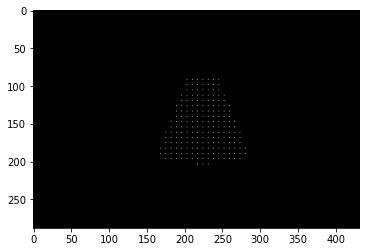

In [60]:
LiDAR_sampling("cones/v_cone.png", 1)

9


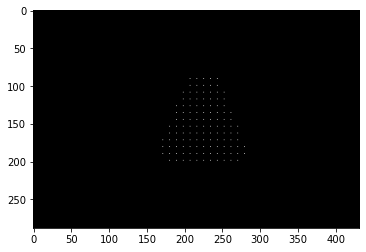

In [61]:
LiDAR_sampling("cones/v_cone.png", 20)

13


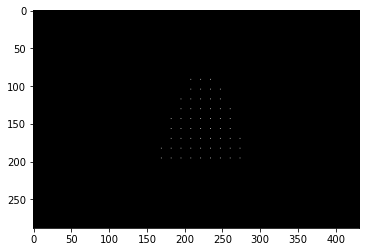

In [62]:
LiDAR_sampling("cones/v_cone.png", 50)

19


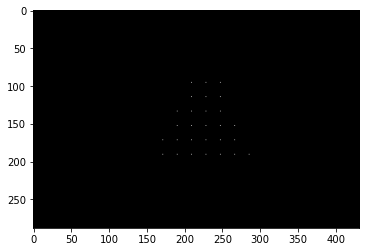

In [63]:
LiDAR_sampling("cones/v_cone.png", 100)

24


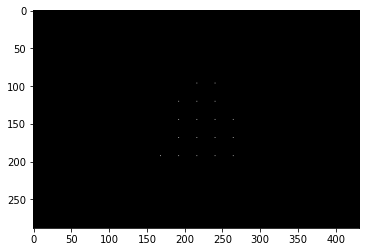

In [64]:
LiDAR_sampling("cones/v_cone.png", 150)

30


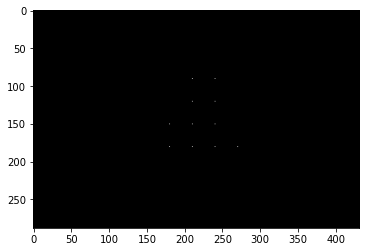

In [65]:
LiDAR_sampling("cones/v_cone.png", 200)